In [9]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 155.6 MB/s eta 0:00:00a 0:00:01


In [33]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 90.8 MB/s eta 0:00:00:00:0100:01


In [34]:
!pip install SimpleITK
!pip install scipy
!pip install matplotlib


In [15]:
from google.cloud import storage
import os

client = storage.Client()

bucket_name = 'marketplace-p115jwl6'  
image_1_path = 'MICCAI FLARE22/114/artifactFiles/FLARE22Train/images/FLARE22_Tr_0031_0000.nii.gz'
image_2_path = 'MICCAI FLARE22/114/artifactFiles/FLARE22Train/images/FLARE22_Tr_0003_0000.nii.gz'

bucket = client.get_bucket(bucket_name)

output_dir = 'ch13_ds'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

blob1 = bucket.blob(image_1_path)
local_file_path1 = os.path.join(output_dir, 'FLARE22_Tr_0031_0000.nii.gz')
blob1.download_to_filename(local_file_path1)
print(f"Downloaded: {local_file_path1}")

blob2 = bucket.blob(image_2_path)
local_file_path2 = os.path.join(output_dir, 'FLARE22_Tr_0003_0000.nii.gz')
blob2.download_to_filename(local_file_path2)
print(f"Downloaded: {local_file_path2}")


Downloaded: ch13_ds/FLARE22_Tr_0031_0000.nii.gz
Downloaded: ch13_ds/FLARE22_Tr_0003_0000.nii.gz


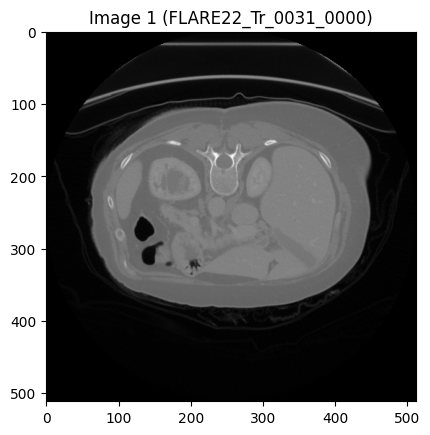

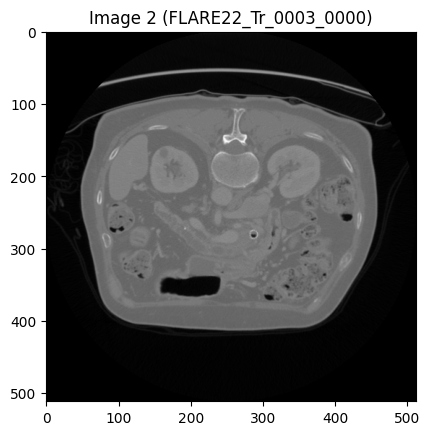

In [27]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

image1_path = 'ch13_ds/FLARE22_Tr_0031_0000.nii.gz'
image2_path = 'ch13_ds/FLARE22_Tr_0003_0000.nii.gz'

img1 = sitk.ReadImage(image1_path)
img2 = sitk.ReadImage(image2_path)

def show_image(image, title="Image"):
    array = sitk.GetArrayViewFromImage(image)
    mid_slice = array[array.shape[0] // 2]  #the middle slice
    plt.imshow(mid_slice, cmap='gray')
    plt.title(title)
    plt.show()

show_image(img1, "Image 1 (FLARE22_Tr_0031_0000)")
show_image(img2, "Image 2 (FLARE22_Tr_0003_0000)")


Optimized Parameters: [0. 0. 0.]
Computation Time: 1.89 seconds


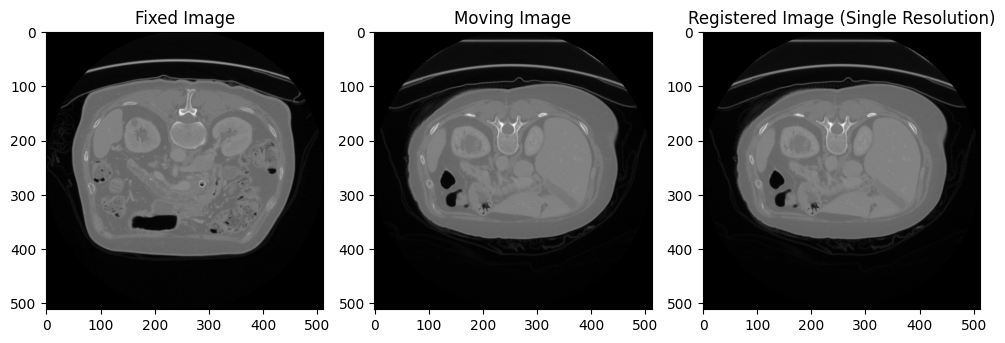

Optimized Parameters: [0. 0. 0.]
Computation Time: 2.93 seconds


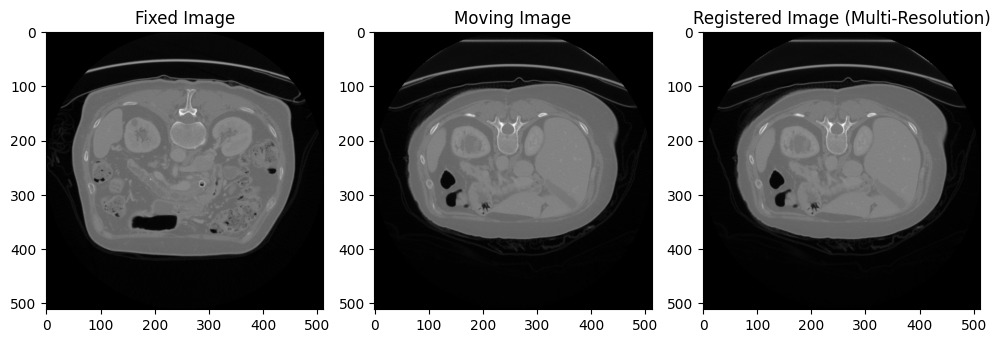

(array([[-0.81789137, -0.81789137, -0.81789137, ..., -0.81789137,
         -0.81789137, -0.81789137],
        [-0.81789137, -0.81789137, -0.81789137, ..., -0.81789137,
         -0.81789137, -0.81789137],
        [-0.81789137, -0.81789137, -0.81789137, ..., -0.81789137,
         -0.81789137, -0.81789137],
        ...,
        [-0.81789137, -0.81789137, -0.81789137, ..., -0.81789137,
         -0.81789137, -0.81789137],
        [-0.81789137, -0.81789137, -0.81789137, ..., -0.81789137,
         -0.81789137, -0.81789137],
        [-0.81789137, -0.81789137, -0.81789137, ..., -0.81789137,
         -0.81789137, -0.81789137]]),
 array([[ 1.,  0.,  0.],
        [-0.,  1.,  0.],
        [ 0.,  0.,  1.]]))

In [39]:
import SimpleITK as sitk
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

def load_and_preprocess_nifti_image(file_path):
    img = sitk.ReadImage(file_path)
    img_array = sitk.GetArrayFromImage(img)
    middle_slice = img_array[img_array.shape[0] // 2]
    middle_slice = middle_slice.astype(np.float64) / np.max(middle_slice)
    return middle_slice

def affine_transform_2d_double(Iin, M, order=3, mode=2, ImageSize=None):
    boundaries = ['reflect', 'grid-mirror', 'constant', 'grid-constant', 'nearest', 'mirror', 'grid-wrap', 'wrap']
    if ImageSize is None:
        ImageSize = [Iin.shape[0], Iin.shape[1]]
    
    boundary = boundaries[mode]
    x, y = np.meshgrid(np.arange(ImageSize[1]), np.arange(ImageSize[0]))

    mean_out = np.array(ImageSize) / 2
    mean_in = np.array(Iin.shape[:2]) / 2

    xd = x - mean_out[1]
    yd = y - mean_out[0]

    Tlocalx = mean_in[1] + M[0, 0] * xd + M[0, 1] * yd + M[0, 2] * 1
    Tlocaly = mean_in[0] + M[1, 0] * xd + M[1, 1] * yd + M[1, 2] * 1

    Iout = map_coordinates(Iin, [Tlocaly, Tlocalx], order=order, mode=boundary)
    return Iout

def ncc(fixed_image, moving_image):
    fixed_mean = np.mean(fixed_image)
    moving_mean = np.mean(moving_image)
    fixed_diff = fixed_image - fixed_mean
    moving_diff = moving_image - moving_mean
    numerator = np.sum(fixed_diff * moving_diff)
    fixed_var = np.sum(fixed_diff ** 2)
    moving_var = np.sum(moving_diff ** 2)
    denominator = np.sqrt(fixed_var * moving_var)
    if denominator == 0:
        return 0
    ncc_value = numerator / denominator
    return -ncc_value  

def downsample_image(image, factor):
    return cv2.resize(image, (image.shape[1] // factor, image.shape[0] // factor), interpolation=cv2.INTER_LINEAR)

def rigid_registration_single_resolution(Imoving_path, Ifixed_path, epsilon=0.001, order=3, visualize=True):
    Imoving = load_and_preprocess_nifti_image(Imoving_path)
    Ifixed = load_and_preprocess_nifti_image(Ifixed_path)

    x = np.array([0, 0, 0])  # [tx, ty, theta]
    scale = np.array([1, 1, 0.001])

    start_time = time.time()
    
    result = minimize(
        lambda par: affine_registration_function(par, scale, Imoving, Ifixed, 'nc', 'r', order),
        x.astype(np.double),
        method='L-BFGS-B',
        options={'eps': epsilon, 'maxls': 50}
    )
    computation_time = time.time() - start_time

    x = result.x * scale

    M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                  [-np.sin(x[2]), np.cos(x[2]), x[1]],
                  [0, 0, 1]])
    Icor = affine_transform_2d_double(Imoving, M, order)

    if visualize:
        print(f'Optimized Parameters: {x}')
        print(f'Computation Time: {computation_time:.2f} seconds')
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(Ifixed, cmap='gray')
        plt.title('Fixed Image')
        plt.subplot(1, 3, 2)
        plt.imshow(Imoving, cmap='gray')
        plt.title('Moving Image')
        plt.subplot(1, 3, 3)
        plt.imshow(Icor, cmap='gray')
        plt.title('Registered Image (Single Resolution)')
        plt.tight_layout()
        plt.show()

    return Icor, M

def rigid_registration_multi_resolution(Imoving_path, Ifixed_path, levels=3, epsilon=0.001, order=3, visualize=True):
    Imoving = load_and_preprocess_nifti_image(Imoving_path)
    Ifixed = load_and_preprocess_nifti_image(Ifixed_path)

    x = np.array([0, 0, 0])  # [tx, ty, theta]
    scale = np.array([1, 1, 0.001])

    start_time = time.time()

    for level in range(levels - 1, -1, -1):
        factor = 2 ** level
        Imoving_resized = downsample_image(Imoving, factor)
        Ifixed_resized = downsample_image(Ifixed, factor)
        level_epsilon = epsilon * factor
        max_iterations = 20 if level > 0 else 50

        result = minimize(
            lambda par: affine_registration_function(par, scale, Imoving_resized, Ifixed_resized, 'nc', 'r', order),
            x.astype(np.double),
            method='L-BFGS-B',
            options={'eps': level_epsilon, 'maxls': max_iterations}
        )
        x = result.x

    computation_time = time.time() - start_time
    x = x * scale

    M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                  [-np.sin(x[2]), np.cos(x[2]), x[1]],
                  [0, 0, 1]])
    Icor = affine_transform_2d_double(Imoving, M, order)

    if visualize:
        print(f'Optimized Parameters: {x}')
        print(f'Computation Time: {computation_time:.2f} seconds')
        plt.figure(figsize=(10, 8))
        plt.subplot(1, 3, 1)
        plt.imshow(Ifixed, cmap='gray')
        plt.title('Fixed Image')
        plt.subplot(1, 3, 2)
        plt.imshow(Imoving, cmap='gray')
        plt.title('Moving Image')
        plt.subplot(1, 3, 3)
        plt.imshow(Icor, cmap='gray')
        plt.title('Registered Image (Multi-Resolution)')
        plt.tight_layout()
        plt.show()

    return Icor, M

def affine_registration_function(par, scale, Imoving, Ifixed, mtype, ttype, order):
    x = par * scale
    M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                  [-np.sin(x[2]), np.cos(x[2]), x[1]],
                  [0, 0, 1]])

    Icor = affine_transform_2d_double(Imoving, M, order)
    return ncc(Ifixed, Icor)

Imoving_path = 'ch13_ds/FLARE22_Tr_0031_0000.nii.gz'
Ifixed_path = 'ch13_ds/FLARE22_Tr_0003_0000.nii.gz'

rigid_registration_single_resolution(Imoving_path, Ifixed_path, epsilon=0.01, order=3, visualize=True)

rigid_registration_multi_resolution(Imoving_path, Ifixed_path, levels=3, epsilon=0.01, order=3, visualize=True)
